In [1]:
from pprint import pprint

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from IPython.display import display, Markdown

In [4]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, explained_variance_score

In [5]:
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier

In [6]:
import optuna as opt

In [7]:
pd.set_option('display.max_rows', 99)
pd.set_option('display.max_columns', 99)

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer

In [9]:
spark = SparkSession.builder \
        .appName('AirBNB - Analysis') \
        .getOrCreate()

In [10]:
data = spark.read.csv('data.csv', header=True, sep=',', inferSchema=True)
data.count()

7146

# Raw data types

|Name|Inferred Type|
|:----:|:---:|
|host_is_superhost|boolean `[t, f]`|
|cancellation_policy|categorical|
|instant_bookable|boolean `[t, f]`|
|host_total_listings_count|integer|
|neighbourhood_cleansed|categorical|
|latitude|float|
|longitude|float|
|property_type|categorical|
|room_type|categorical|
|accommodates|integer|
|bathrooms|integer|
|bedrooms|integer|
|beds|integer|
|bed_type|categorical|
|minimum_nights|integer|
|number_of_reviews|integer|
|review_scores_rating|integer|
|review_scores_accuracy|integer|
|review_scores_cleanliness|integer|
|review_scores_checkin|integer|
|review_scores_communication|integer|
|review_scores_location|integer|
|review_scores_value|integer|
|review_scores_rating_na|integer|
|review_scores_accuracy_na|integer|
|review_scores_cleanliness_na|integer|
|review_scores_checkin_na|integer|
|review_scores_communication_na|integer|
|review_scores_location_na|integer|
|review_scores_value_na|integer|
|price|float|
|bedrooms_na|boolean `[0, 1]`|
|bathrooms_na|boolean `[0, 1]`|
|beds_na| boolean `[0, 1]`|

---

# Data Preprocessing with PySpark

In [11]:
# CONVERT BOOLEAN STRING DATA INTO BOOLEAN TYPE

data = data \
    .withColumn('host_is_superhost', when(col('host_is_superhost') == 't', True).otherwise(False)) \
    .withColumn('instant_bookable', when(col('instant_bookable') == 't', True).otherwise(False)) \
    .withColumn('bedrooms_na', when(col('bedrooms_na') == 1, True).otherwise(False)) \
    .withColumn('bathrooms_na', when(col('bedrooms_na') == 1, True).otherwise(False)) \
    .withColumn('beds_na', when(col('bedrooms_na') == 1, True).otherwise(False)) \
    .withColumn('review_scores_rating_na', when(col('review_scores_rating_na') == 1, True).otherwise(False)) \
    .withColumn('review_scores_accuracy_na', when(col('review_scores_accuracy_na') == 1, True).otherwise(False)) \
    .withColumn('review_scores_cleanliness_na', when(col('review_scores_cleanliness_na') == 1, True).otherwise(False)) \
    .withColumn('review_scores_checkin_na', when(col('review_scores_checkin_na') == 1, True).otherwise(False)) \
    .withColumn('review_scores_communication_na', when(col('review_scores_communication_na') == 1, True).otherwise(False)) \
    .withColumn('review_scores_location_na', when(col('review_scores_location_na') == 1, True).otherwise(False)) \
    .withColumn('review_scores_value_na', when(col('review_scores_value_na') == 1, True).otherwise(False))

In [13]:
col_cat = ['cancellation_policy', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']

col_indexer = StringIndexer(
    inputCols=col_cat,
    outputCols=[f'{col}_index' for col in col_cat],
    stringOrderType='frequencyDesc'
)
data_indexed = col_indexer.fit(data).transform(data)

data_indexed.limit(7).toPandas()

,host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,bedrooms_na,bathrooms_na,beds_na,review_scores_rating_na,review_scores_accuracy_na,review_scores_cleanliness_na,review_scores_checkin_na,review_scores_communication_na,review_scores_location_na,review_scores_value_na,neighbourhood_cleansed_index,room_type_index,bed_type_index,cancellation_policy_index,property_type_index
0,True,moderate,True,1.0,Western Addition,37.76931,-122.43386,Apartment,Entire home/apt,3.0,1.0,1.0,2.0,Real Bed,1.0,180.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,170.0,False,False,False,False,False,False,False,False,False,False,2.0,0.0,0.0,1.0,0.0
1,False,strict_14_with_grace_period,False,2.0,Bernal Heights,37.74511,-122.42102,Apartment,Entire home/apt,5.0,1.0,2.0,3.0,Real Bed,30.0,111.0,98.0,10.0,10.0,10.0,10.0,10.0,9.0,235.0,False,False,False,False,False,False,False,False,False,False,5.0,0.0,0.0,0.0,0.0
2,False,strict_14_with_grace_period,False,10.0,Haight Ashbury,37.76669,-122.45250,Apartment,Private room,2.0,4.0,1.0,1.0,Real Bed,32.0,17.0,85.0,8.0,8.0,9.0,9.0,9.0,8.0,65.0,False,False,False,False,False,False,False,False,False,False,6.0,1.0,0.0,0.0,0.0
3,False,strict_14_with_grace_period,False,10.0,Haight Ashbury,37.76487,-122.45183,Apartment,Private room,2.0,4.0,1.0,1.0,Real Bed,32.0,8.0,93.0,9.0,9.0,10.0,10.0,9.0,9.0,65.0,False,False,False,False,False,False,False,False,False,False,6.0,1.0,0.0,0.0,0.0
4,False,strict_14_with_grace_period,False,2.0,Western Addition,37.77525,-122.43637,House,Entire home/apt,5.0,1.5,2.0,2.0,Real Bed,7.0,27.0,97.0,10.0,10.0,10.0,10.0,10.0,9.0,785.0,False,False,False,False,False,False,False,False,False,False,2.0,0.0,0.0,0.0,1.0
5,False,moderate,False,1.0,Western Addition,37.78471,-122.44555,Apartment,Entire home/apt,6.0,1.0,2.0,3.0,Real Bed,2.0,31.0,90.0,9.0,8.0,10.0,10.0,9.0,9.0,255.0,False,False,False,False,False,False,False,False,False,False,2.0,0.0,0.0,1.0,0.0
6,True,strict_14_with_grace_period,True,2.0,Mission,37.75919,-122.42237,Condominium,Private room,3.0,1.0,1.0,2.0,Real Bed,1.0,647.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,139.0,False,False,False,False,False,False,False,False,False,False,0.0,1.0,0.0,0.0,2.0


---

# Convert to Pandas

In [14]:
df = data_indexed.toPandas()

---

# Analyse Data

## Select columns to use

In [15]:
cols_types = {
    'host_is_superhost': 'bool', 'instant_bookable': 'bool',
    'host_total_listings_count': 'int', 'latitude': 'float',
    'longitude': 'float', 'accommodates': 'int', 'bathrooms': 'int',
    'bedrooms': 'int', 'beds': 'int', 'minimum_nights': 'int', 'number_of_reviews': 'int',
    'review_scores_rating': 'int', 'review_scores_accuracy': 'int',
    'review_scores_cleanliness': 'int', 'review_scores_checkin': 'int',
    'review_scores_communication': 'int', 'review_scores_location': 'int',
    'review_scores_value': 'int', 'price': 'float', 'bedrooms_na': 'bool', 'bathrooms_na': 'bool',
    'beds_na': 'bool', 'review_scores_rating_na': 'bool', 'review_scores_accuracy_na': 'bool',
    'review_scores_cleanliness_na': 'bool', 'review_scores_checkin_na': 'bool',
    'review_scores_communication_na': 'bool', 'review_scores_location_na': 'bool',
    'review_scores_value_na': 'bool', 'cancellation_policy_index': 'int',
    'neighbourhood_cleansed_index': 'int', 'property_type_index': 'int',
    'room_type_index': 'int', 'bed_type_index': 'int'
}

cols_types_cats = {
    'cancellation_policy_index': 'category',
    'neighbourhood_cleansed_index': 'category', 'property_type_index': 'category',
    'room_type_index': 'category', 'bed_type_index': 'category'
}

In [16]:
df = df[cols_types.keys()]
df = df.astype(cols_types).astype(cols_types_cats)

In [17]:
df.isna().sum().value_counts()

0    34
dtype: int64

In [18]:
df.dtypes

host_is_superhost                     bool
instant_bookable                      bool
host_total_listings_count            int64
latitude                           float64
longitude                          float64
accommodates                         int64
bathrooms                            int64
bedrooms                             int64
beds                                 int64
minimum_nights                       int64
number_of_reviews                    int64
review_scores_rating                 int64
review_scores_accuracy               int64
review_scores_cleanliness            int64
review_scores_checkin                int64
review_scores_communication          int64
review_scores_location               int64
review_scores_value                  int64
price                              float64
bedrooms_na                           bool
bathrooms_na                          bool
beds_na                               bool
review_scores_rating_na               bool
review_scor

In [19]:
df.head()

,host_is_superhost,instant_bookable,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,bedrooms_na,bathrooms_na,beds_na,review_scores_rating_na,review_scores_accuracy_na,review_scores_cleanliness_na,review_scores_checkin_na,review_scores_communication_na,review_scores_location_na,review_scores_value_na,cancellation_policy_index,neighbourhood_cleansed_index,property_type_index,room_type_index,bed_type_index
0,True,True,1,37.76931,-122.43386,3,1,1,2,1,180,97,10,10,10,10,10,10,170.0,False,False,False,False,False,False,False,False,False,False,1,2,0,0,0
1,False,False,2,37.74511,-122.42102,5,1,2,3,30,111,98,10,10,10,10,10,9,235.0,False,False,False,False,False,False,False,False,False,False,0,5,0,0,0
2,False,False,10,37.76669,-122.45250,2,4,1,1,32,17,85,8,8,9,9,9,8,65.0,False,False,False,False,False,False,False,False,False,False,0,6,0,1,0
3,False,False,10,37.76487,-122.45183,2,4,1,1,32,8,93,9,9,10,10,9,9,65.0,False,False,False,False,False,False,False,False,False,False,0,6,0,1,0
4,False,False,2,37.77525,-122.43637,5,1,2,2,7,27,97,10,10,10,10,10,9,785.0,False,False,False,False,False,False,False,False,False,False,0,2,1,0,0


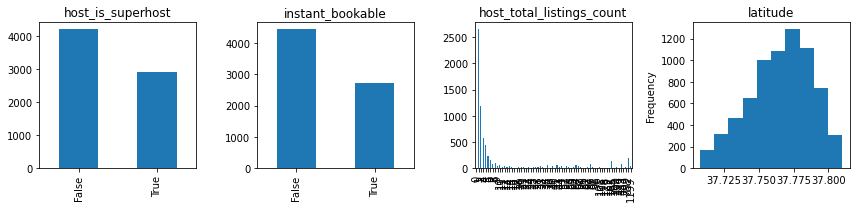

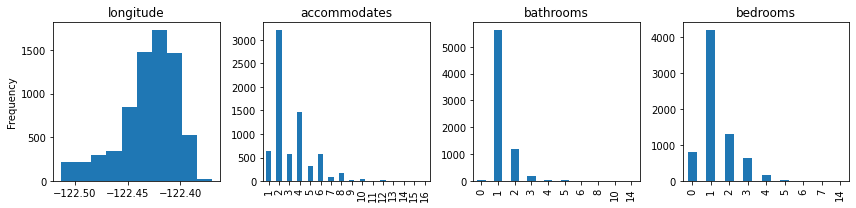

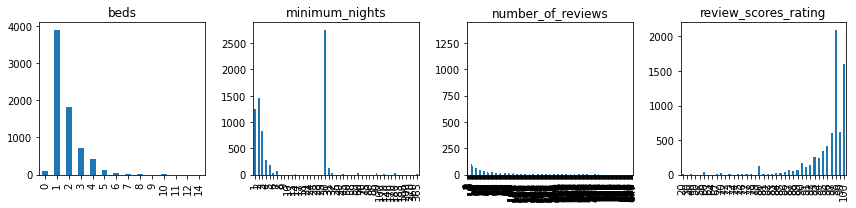

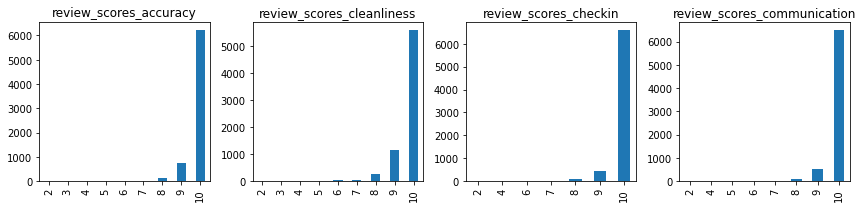

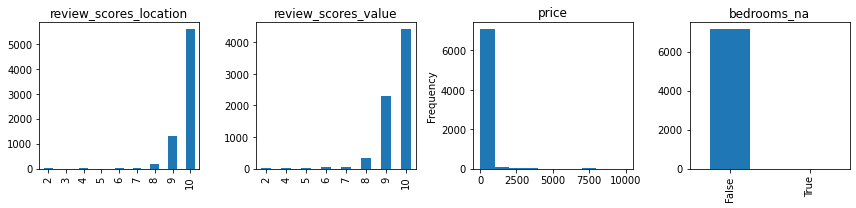

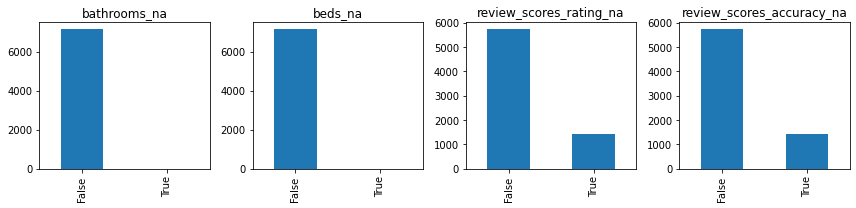

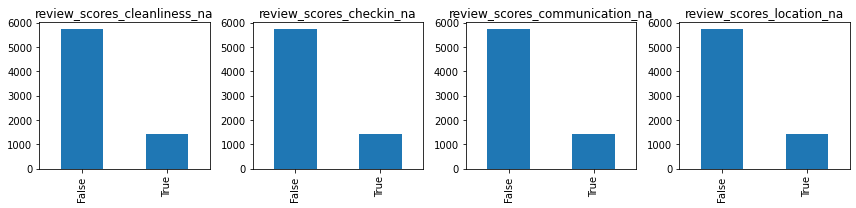

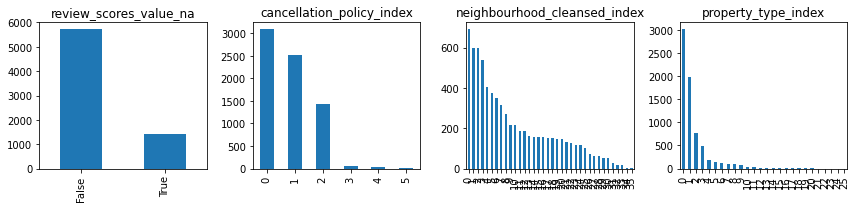

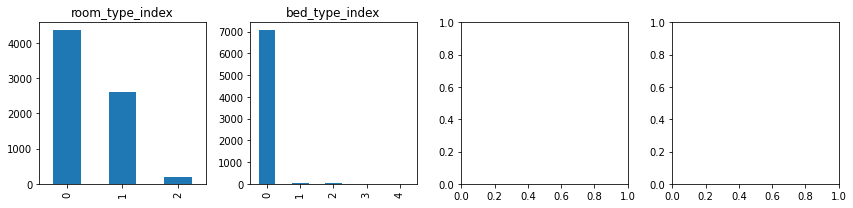

In [20]:
width = 4
heigth = 1

for i in range(0, df.shape[1], width):
    fig, ax = plt.subplots(heigth, width, figsize=(width*3, heigth*3))
    
    for j in range(width):
        if i + j < df.shape[1]:
            col = df.columns[i + j]
            if df.dtypes[col] in ['float']:
                df[col].plot.hist(ax=ax[j], title=col)
            else:
                df[col].value_counts().sort_index().plot.bar(ax=ax[j], title=col)
    plt.tight_layout()
    plt.show()
    plt.close()

## Feature Understanding

* **Feature count variables (e.g.: 'bathrooms', 'bedrooms', 'beds')**
  - Look as expected;
  - The most frequent numbers usually are the small numbers except for 0 as it is uncommom to have a house without bathroom or a bed.
* **Reviews**
  - Usually client reviews are not the most informative variables
  - Overestimation of the actual grade of a service when the client enjoys it
  - Underestimation of the actual grade of a service when the client dislikes it
  - The distribution of the reviews is forced to be most frequent at the maximum value and very low frequency to the lowest values.
  - The distance between grades 9 and 10 is different from the distance between grades 1 and 2
* **Boolean columns**
  - `na` columns
    * The actual meaning is unkonw
    * Assuming it represents information of missing values in the column it refers to
      - If true there is a method to fill the missing value as there are no missing data in the dataset
  - host_is_superhost and instant_bookable
    * Seem to be fair distributed as they both represent a less frequent feature for the service

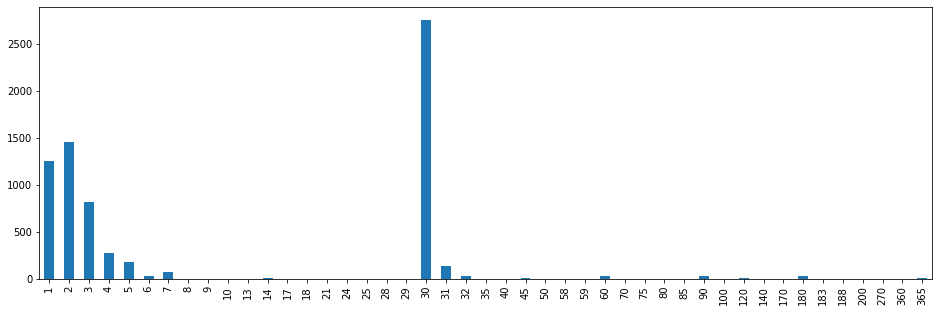

In [21]:
df['minimum_nights'].value_counts().sort_index().plot.bar(figsize=(16, 5))
plt.show()
plt.close()

* **Minimum nights**
  - Understandable distribution
  - Largest number in the lowest end
  - Peak in number of days equal a month
  - Rare ocurrencies of very large minimum amount of days

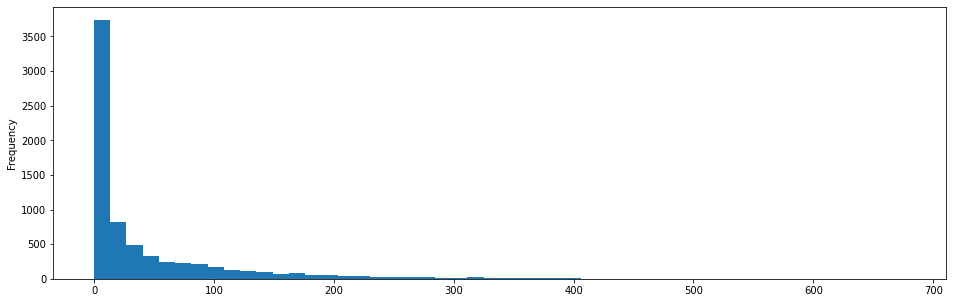

In [22]:
df['number_of_reviews'].plot.hist(figsize=(16, 5), bins=50)
plt.show()
plt.close()

* **Number of reviews**
  - Expected distribution
  - Most of the times the user does not review the service
  - The distribution will be similar to an exponential distribution
    * Large near zero
    * Exponential decay
    * Possible for large values to appear
  - Doesn't make much sense to use for a regression problem to predict the price
    * The number of reviews is a result of the number of clients
    * Naturally highly priced services are considered by a small number of people
    * Meaning the two features would be highly correlated but not actually adding information to the problem

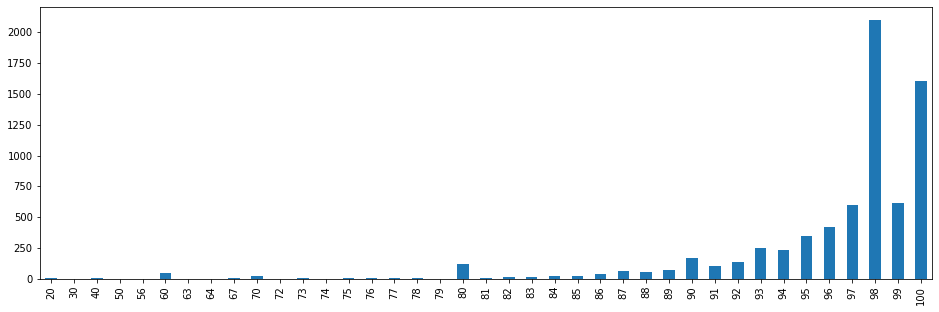

In [23]:
df['review_scores_rating'].value_counts().sort_index().plot.bar(figsize=(16, 5))
plt.show()
plt.close()

* **Review Scores Rating**
  - No direct meaning for this column by looking at just the name
  - Could be an aggregation result of the other review metrics

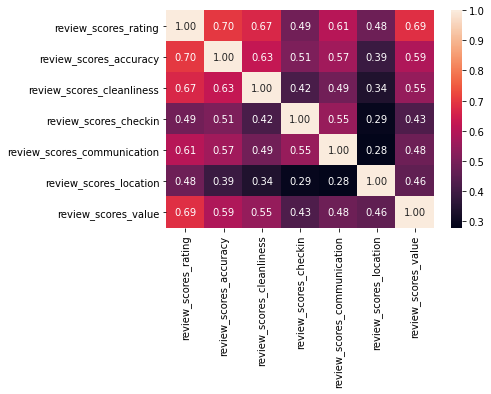

In [24]:
aux = df[[col for col in df.columns if 'review_' in col if '_na' not in col]].corr()
sns.heatmap(aux, annot=True, fmt='.02f')
plt.show()
plt.close()

In [25]:
# TEST VALUES OF THE NA COLUMN
for col in df.columns:
    if 'na' in col:
        display(Markdown(f'**{col} - True**'))
        print(df[df[col]][[col.split('_na')[0], col]].value_counts())
        
        # display(Markdown(f'### {col} - False'))
        # print(df[~df[col]][[col.split('_na')[0], col]].value_counts())
        
        display(Markdown('---'))

**bedrooms_na - True**

bedrooms  bedrooms_na
1         True           2
dtype: int64


---

**bathrooms_na - True**

bathrooms  bathrooms_na
3          True            1
1          True            1
dtype: int64


---

**beds_na - True**

beds  beds_na
4     True       1
1     True       1
dtype: int64


---

**review_scores_rating_na - True**

review_scores_rating  review_scores_rating_na
98                    True                       1421
dtype: int64


---

**review_scores_accuracy_na - True**

review_scores_accuracy  review_scores_accuracy_na
10                      True                         1425
dtype: int64


---

**review_scores_cleanliness_na - True**

review_scores_cleanliness  review_scores_cleanliness_na
10                         True                            1424
dtype: int64


---

**review_scores_checkin_na - True**

review_scores_checkin  review_scores_checkin_na
10                     True                        1427
dtype: int64


---

**review_scores_communication_na - True**

review_scores_communication  review_scores_communication_na
10                           True                              1423
dtype: int64


---

**review_scores_location_na - True**

review_scores_location  review_scores_location_na
10                      True                         1427
dtype: int64


---

**review_scores_value_na - True**

review_scores_value  review_scores_value_na
10                   True                      1428
dtype: int64


---

In [26]:
# TEST VALUES OF THE REFERED COLUMN
for col in df.columns:
    if 'na' in col:
        ref_col = col.split('_na')[0]
        value = df[df[col]][[ref_col, col]].value_counts().index[0][0]
        print(value)
        print(df[df[ref_col] == value][[ref_col, col]].value_counts())
        display(Markdown('---'))

1
bedrooms  bedrooms_na
1         False          4197
          True              2
dtype: int64


---

3
bathrooms  bathrooms_na
3          False           185
           True              1
dtype: int64


---

4
beds  beds_na
4     False      408
      True         1
dtype: int64


---

98
review_scores_rating  review_scores_rating_na
98                    True                       1421
                      False                       677
dtype: int64


---

10
review_scores_accuracy  review_scores_accuracy_na
10                      False                        4802
                        True                         1425
dtype: int64


---

10
review_scores_cleanliness  review_scores_cleanliness_na
10                         False                           4184
                           True                            1424
dtype: int64


---

10
review_scores_checkin  review_scores_checkin_na
10                     False                       5176
                       True                        1427
dtype: int64


---

10
review_scores_communication  review_scores_communication_na
10                           False                             5079
                             True                              1423
dtype: int64


---

10
review_scores_location  review_scores_location_na
10                      False                        4157
                        True                         1427
dtype: int64


---

10
review_scores_value  review_scores_value_na
10                   False                     2981
                     True                      1428
dtype: int64


---

* **NA Columns**
  - Seem to add little information
  - All of the features they apparently refer to have usually the same value when the `na` column is true
  - No actual description of what is the intended use of this columns
  - Splits the reference column into two different categories that might be useful

## Feature selection

### PCA

In [27]:
def normalize(mat):
    res = list()
    for arr in mat:
        aux = (arr ** 2)
        res.append(aux / aux.sum())
    return np.array(res)

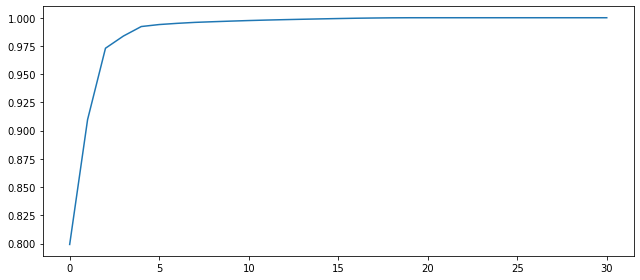

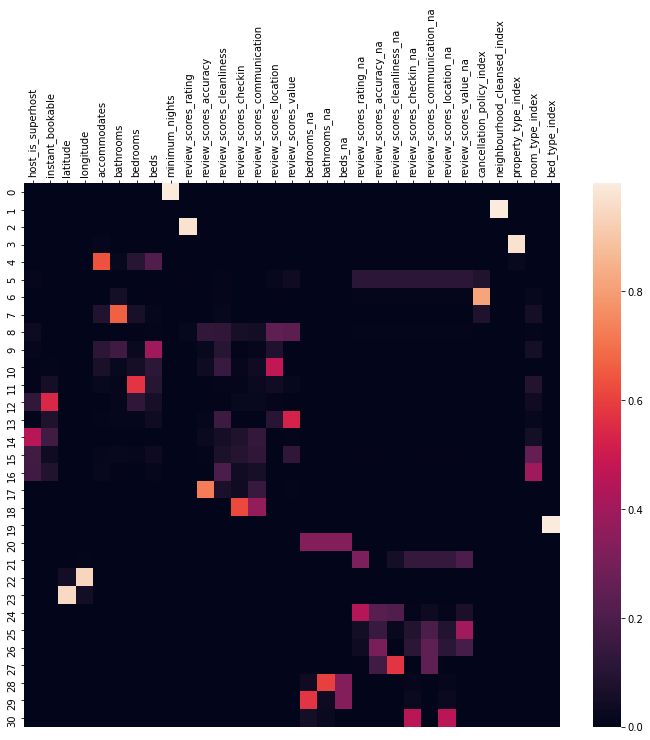

In [28]:
ignore = ['price', 'number_of_reviews', 'host_total_listings_count']
aux = df[[col for col in df.columns if col not in ignore]]

pca = PCA()
pca.fit(aux.values)

plt.figure(figsize=(9, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
sns.heatmap(normalize(pca.components_), xticklabels=aux.columns)
plt.gca().xaxis.tick_top()
plt.xticks(rotation=90)
plt.show()
plt.close()

* **PCA interpretation**
  - PCA computes the principal components of a dataset based on the features of it
  - Each new feature is assigned a value of "importance" based on the explained variance ratio
  - A PCA feature with high "importance" is a result of a linear combination of the original features
  - The features with the highest value in the linear combination to build the high importance PCA feature could be considered a high importance feature

* **BUT** is it important to consider that the methodology to calculate the principal components using PCA is originally assuming continuous values for the features and not categorical or boolean values, this reduces the validity of the analysis for this dataset. However it is still a valid analysis with low robustness.

### Correlation

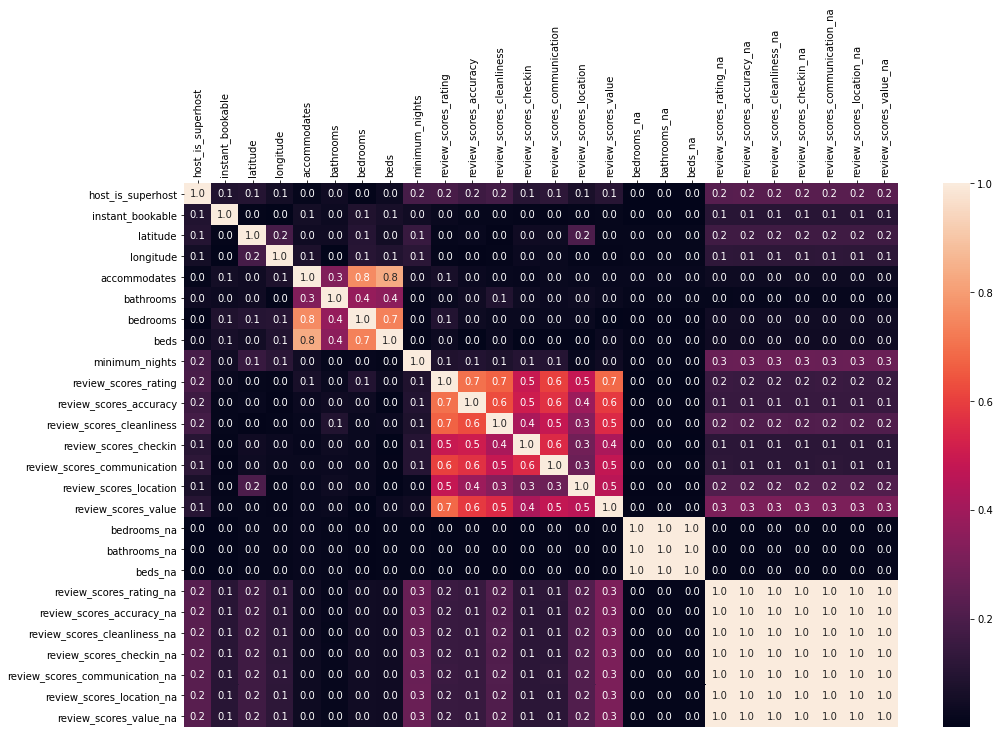

In [29]:
ignore = ['price', 'number_of_reviews', 'host_total_listings_count']
aux = df[[col for col in df.columns if col not in ignore]]

corr = aux.corr().abs()
plt.figure(figsize=(16, 10))
sns.heatmap(corr, annot=True, fmt='.01f')
plt.gca().xaxis.tick_top()
plt.xticks(rotation=90)
plt.show()
plt.close()

* **Correlation interpretation**
  - This is a weak metric in this situation as there are many categorical and boolean features
  - Features with a high correlation could add redundant information and bias to the model

In [30]:
# HIGH CORRELATION FEATURES
hcorr = dict()
for name, row in corr[corr > .9].iterrows():
    aux = list()
    for idx in np.where(row > .9)[0].tolist():
        if corr.columns[idx] != name:
            aux.append(corr.columns[idx])
        if len(aux) > 0:
            hcorr[name] = aux

In [31]:
pprint(hcorr)

{'bathrooms_na': ['bedrooms_na', 'beds_na'],
 'bedrooms_na': ['bathrooms_na', 'beds_na'],
 'beds_na': ['bedrooms_na', 'bathrooms_na'],
 'review_scores_accuracy_na': ['review_scores_rating_na',
                               'review_scores_cleanliness_na',
                               'review_scores_checkin_na',
                               'review_scores_communication_na',
                               'review_scores_location_na',
                               'review_scores_value_na'],
 'review_scores_checkin_na': ['review_scores_rating_na',
                              'review_scores_accuracy_na',
                              'review_scores_cleanliness_na',
                              'review_scores_communication_na',
                              'review_scores_location_na',
                              'review_scores_value_na'],
 'review_scores_cleanliness_na': ['review_scores_rating_na',
                                  'review_scores_accuracy_na',
                    

All of the `na` features are highly correlated and could be reduced to a single feature for each block, instead of multiple features representing de same information.

In [32]:
(df['bedrooms_na'] == df['beds_na']).value_counts()

True    7146
dtype: int64

In [33]:
(df['bedrooms_na'] == df['bathrooms_na']).value_counts()

True    7146
dtype: int64

The three columns `['bedrooms_na', 'beds_na', 'bathrooms_na']` are identical

In [34]:
for col in [
    'review_scores_rating_na',
    'review_scores_cleanliness_na',
    'review_scores_checkin_na',
    'review_scores_communication_na',
    'review_scores_location_na',
    'review_scores_value_na'
]:
    print((df['review_scores_accuracy_na'] == df[col]).value_counts())

True     7142
False       4
dtype: int64
True     7145
False       1
dtype: int64
True     7144
False       2
dtype: int64
True     7144
False       2
dtype: int64
True     7144
False       2
dtype: int64
True     7143
False       3
dtype: int64


All of the `review_scores_*_na` columns are almost all identical

## Features to ignore for regression

* **Based on feature interpretation**
    - `number_of_reviews`: is a result of the price and not a feature
    - `host_total_listings`: is a host feature and does not represent the place to be rent
* **Based on PCA results**
    - Ignore all except for: `minimum_nights`, `review_scores_rating`, `neighbourhood_cleansed_index`, `property_type_index`
* **Based on correlation**
    - Aggregate `bedrooms_na`, `beds_na`, `bathrooms_na` into a single column
    - Aggregate `review_scores_*_na` into a single column

## Apply feature reduction

In [35]:
df.shape

(7146, 34)

In [36]:
ignore = ['number_of_reviews', 'host_total_listings_count']
min_change = df[[col for col in df.columns if col not in ignore]].copy()
min_change.shape

(7146, 32)

In [37]:
max_change = df[['minimum_nights', 'review_scores_rating', 'neighbourhood_cleansed_index', 'property_type_index', 'price']].copy()
max_change.shape

(7146, 5)

In [38]:
ignore = ['number_of_reviews', 'host_total_listings_count']
med_change = df[[col for col in df.columns if col not in ignore]].copy()

med_change['room_na'] = med_change['beds_na'].copy()
med_change = med_change.drop(columns=['bedrooms_na', 'beds_na', 'bathrooms_na'])

med_change['review_scores_na'] = med_change['review_scores_accuracy_na'].copy()
med_change = med_change.drop(columns=[
    'review_scores_accuracy_na',
    'review_scores_rating_na',
    'review_scores_cleanliness_na',
    'review_scores_checkin_na',
    'review_scores_communication_na',
    'review_scores_location_na',
    'review_scores_value_na'
])

med_change.shape

(7146, 24)

# Regression Learning

* **Model Choice**: use Tree based models
  - Categorical features
  - Discrete features
  - Large number of features

* Target Column: `price`
* Feature Column: `~price`

## Auxiliary Functions

In [39]:
def mape(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / y_true)

In [41]:
def evaluate(true, pred):
    return {
        'MSE': mean_squared_error(true, pred),
        'RMSE': np.sqrt(mean_squared_error(true, pred)),
        'MAE': mean_absolute_error(true, pred),
        'MAPE': mape(true, pred),
        'MaxErr': max_error(true, pred)
    }

In [42]:
def prediction_report(true, pred, cmodel, ax, title):
    ax.scatter(pred, true, s=3, alpha=.3)
    ax.plot(np.linspace(*ax.get_xlim()), np.linspace(*ax.get_ylim()), color='red', alpha=.3)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(True, 'both', alpha=.3)
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Ground Truth')

    evals = evaluate(true, pred)
    ax.set_title(title)
    return evals

In [43]:
def test_model(model, sets):
    X_train, y_train, X_test, y_test = sets
    
    model.fit(X_train, y_train)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

    pred = model.predict(X_train)
    _ = prediction_report(y_train, pred, model, ax1, 'Train Error')

    pred = model.predict(X_test)
    aux = prediction_report(y_test, pred, model, ax2, 'Test Error')

    plt.tight_layout()
    plt.show()
    plt.close()

    residue = pred - y_test
    plt.figure(figsize=(10, 2))
    plt.title(f'Residue Distribution | Mean: {residue.mean():.03f}')
    sns.kdeplot(residue)
    sns.rugplot(pred - y_test, height=0.1)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return aux

In [44]:
mevals = dict()

## Using `min_change` DataFrame

In [45]:
aux = min_change.copy()
y = aux.pop('price')
X = aux

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5002, 31), (2144, 31), (5002,), (2144,))

DecisionTreeRegressor


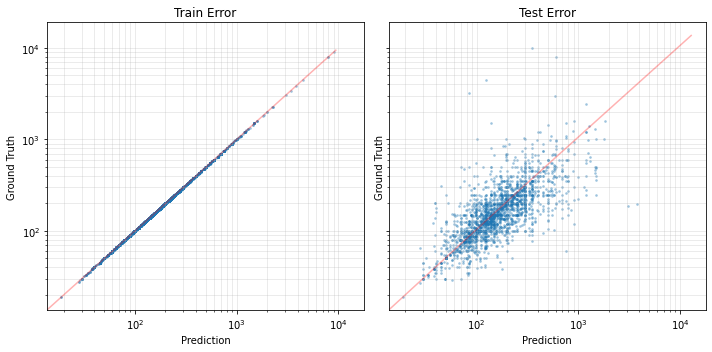

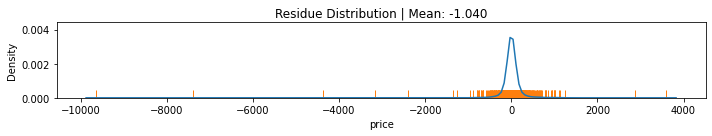

RandomForestRegressor


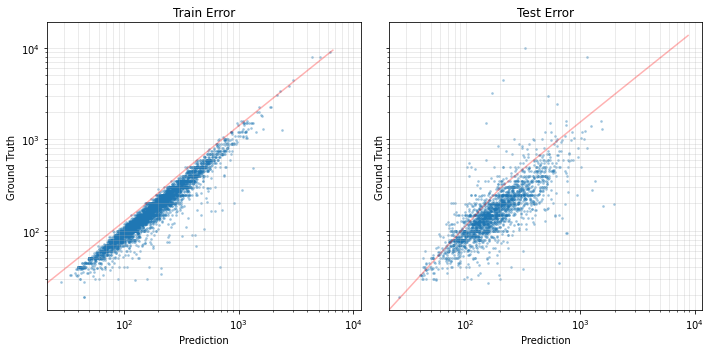

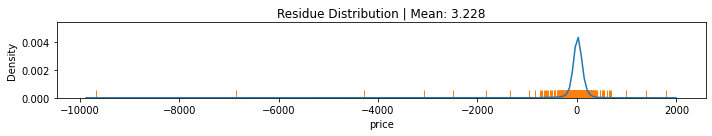

XGBRegressor


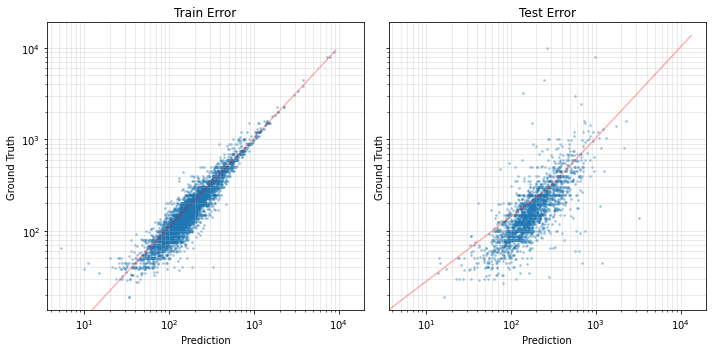

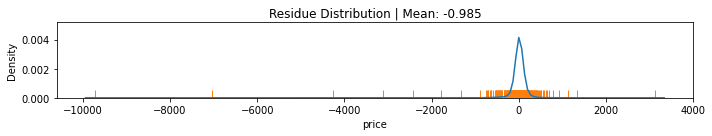

LGBMRegressor


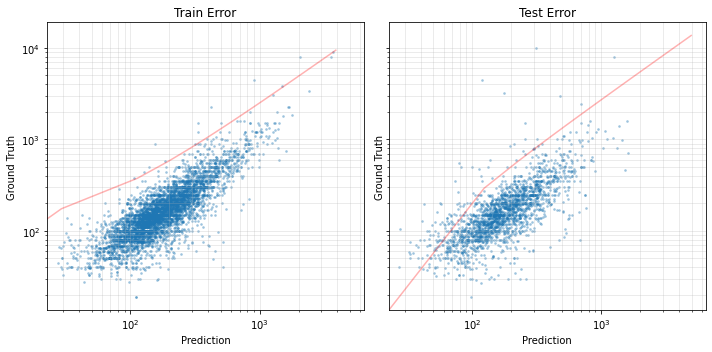

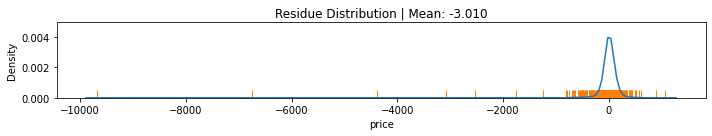

CatBoostRegressor


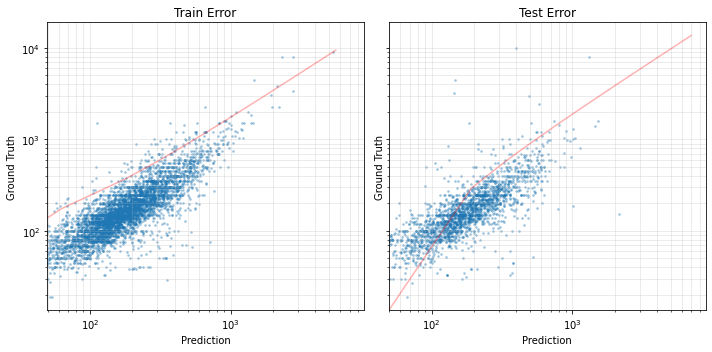

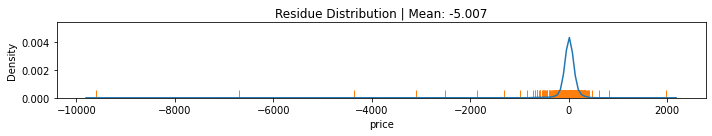

In [46]:
models = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    XGBRegressor(),
    LGBMRegressor(),
    CatBoostRegressor(cat_features=[col for col in X_train.columns if str(X_train.dtypes[col]) == 'category'], verbose=0)
]

for model in models:
    modelname = type(model).__name__
    print(modelname)
    if modelname == 'XGBRegressor':
        # XGB DOES NOT SUPPORT CATEGORICAL TYPES
        mapper = {row['index']: 'int' for _, row in X_train.dtypes.reset_index().iterrows() if str(row[0]) == 'category'}
        sets = (X_train.copy().astype(mapper), y_train.copy(), X_test.copy().astype(mapper), y_test.copy())
    else:
        sets = (X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy())
    mevals[('min_change', modelname)] = test_model(model, sets)

In [47]:
pd.DataFrame(mevals).transpose()

MSE        RMSE        MAE  \
min_change DecisionTreeRegressor  121835.847481  349.049921  98.088153   
           RandomForestRegressor   99065.306112  314.746416  77.260928   
           XGBRegressor           104159.949448  322.738206  80.799053   
           LGBMRegressor           96939.027609  311.350329  81.665777   
           CatBoostRegressor       96430.277981  310.532250  77.925186   

                                      MAPE       MaxErr  
min_change DecisionTreeRegressor  0.433073  9650.000000  
           RandomForestRegressor  0.380651  9667.100000  
           XGBRegressor           0.413412  9731.302490  
           LGBMRegressor          0.435797  9686.009924  
           CatBoostRegressor      0.406516  9603.895304

## Using `med_change` DataFrame

In [48]:
aux = med_change.copy()
y = aux.pop('price')
X = aux

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5002, 23), (2144, 23), (5002,), (2144,))

DecisionTreeRegressor


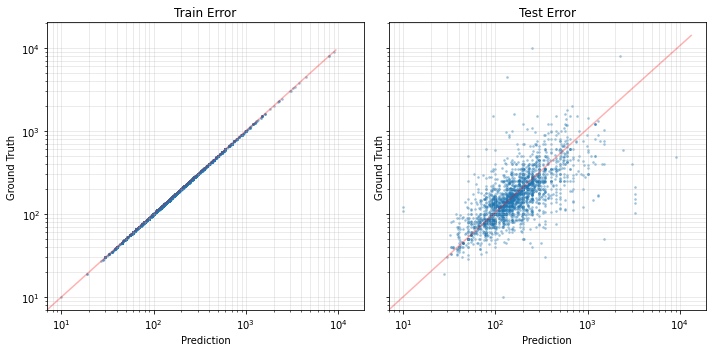

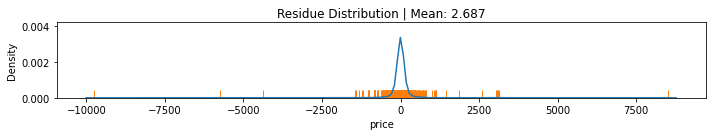

RandomForestRegressor


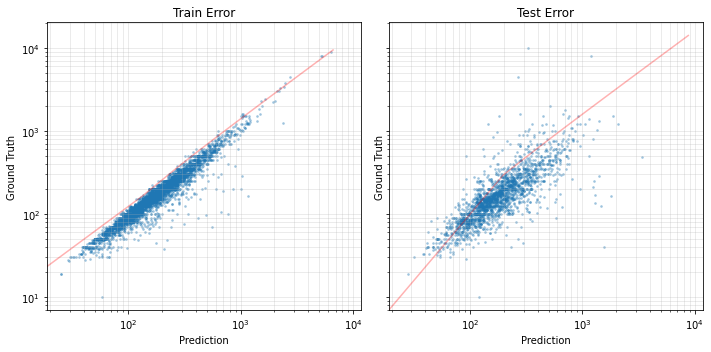

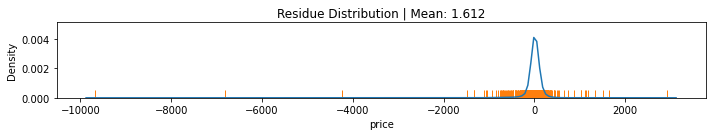

XGBRegressor


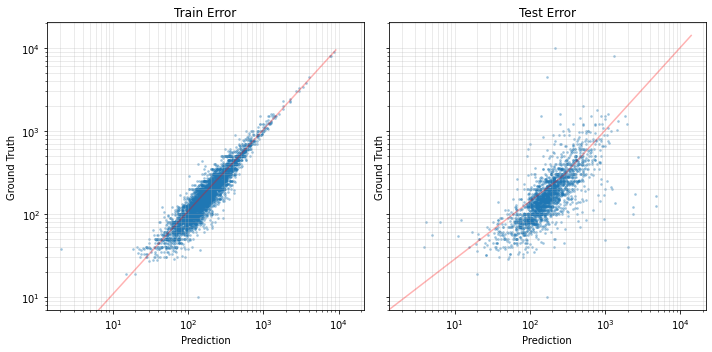

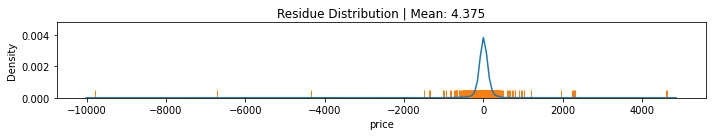

LGBMRegressor


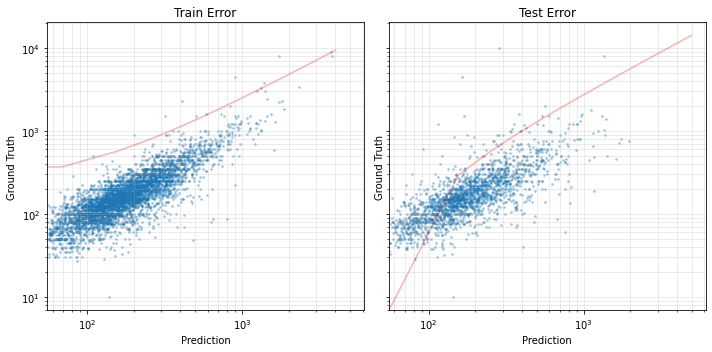

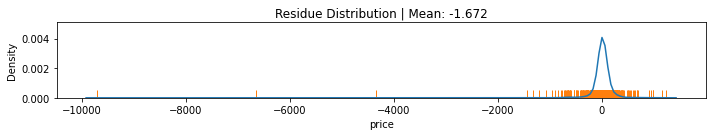

CatBoostRegressor


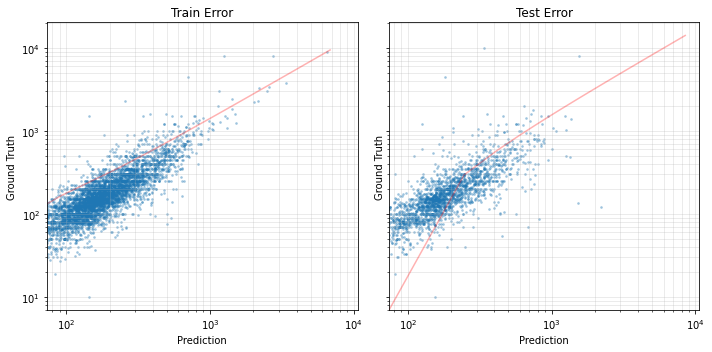

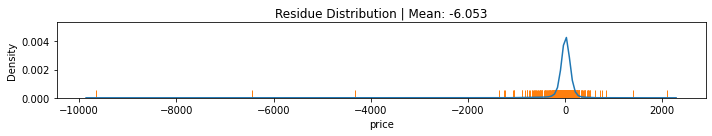

In [49]:
models = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    XGBRegressor(),
    LGBMRegressor(),
    CatBoostRegressor(cat_features=[col for col in X_train.columns if str(X_train.dtypes[col]) == 'category'], verbose=0)
]

for model in models:
    modelname = type(model).__name__
    print(modelname)
    if modelname == 'XGBRegressor':
        # XGB DOES NOT SUPPORT CATEGORICAL TYPES
        mapper = {row['index']: 'int' for _, row in X_train.dtypes.reset_index().iterrows() if str(row[0]) == 'category'}
        sets = (X_train.copy().astype(mapper), y_train.copy(), X_test.copy().astype(mapper), y_test.copy())
    else:
        sets = (X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy())
    mevals[('med_change', modelname)] = test_model(model, sets)

In [50]:
pd.DataFrame(mevals).transpose()

MSE        RMSE         MAE  \
min_change DecisionTreeRegressor  121835.847481  349.049921   98.088153   
           RandomForestRegressor   99065.306112  314.746416   77.260928   
           XGBRegressor           104159.949448  322.738206   80.799053   
           LGBMRegressor           96939.027609  311.350329   81.665777   
           CatBoostRegressor       96430.277981  310.532250   77.925186   
med_change DecisionTreeRegressor  160090.790578  400.113472  108.430504   
           RandomForestRegressor  101251.988599  318.201176   81.393549   
           XGBRegressor           127463.498694  357.020306   92.948819   
           LGBMRegressor           96009.967615  309.854752   87.685232   
           CatBoostRegressor       92885.503070  304.771231   80.513899   

                                      MAPE       MaxErr  
min_change DecisionTreeRegressor  0.433073  9650.000000  
           RandomForestRegressor  0.380651  9667.100000  
           XGBRegressor           0.413412  9731.302490  
           LGBMRegressor          0.435797  9686.009924  
           CatBoostRegressor      0.406516  9603.895304  
med_change DecisionTreeRegressor  0.488585  9751.000000  
           RandomForestRegressor  0.379120  9669.430000  
           XGBRegressor           0.473630  9780.857254  
           LGBMRegressor          0.423749  9715.624661  
           CatBoostRegressor      0.390784  9661.483459

## Using `max_change` DataFrame

In [51]:
aux = med_change.copy()
y = aux.pop('price')
X = aux

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5002, 23), (2144, 23), (5002,), (2144,))

DecisionTreeRegressor


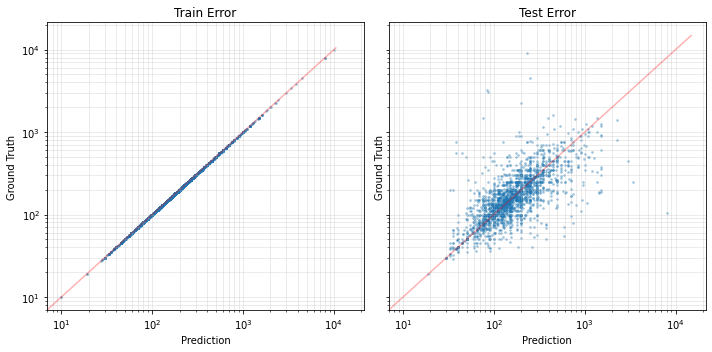

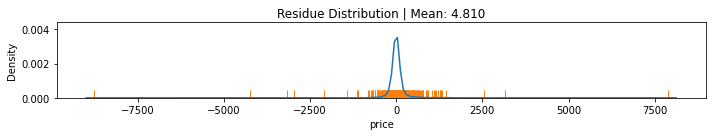

RandomForestRegressor


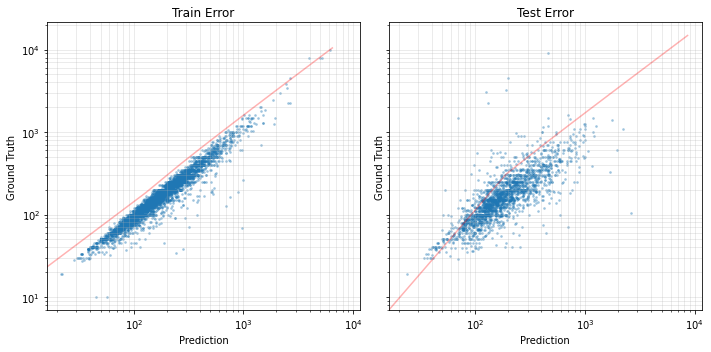

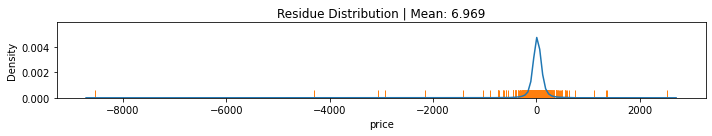

XGBRegressor


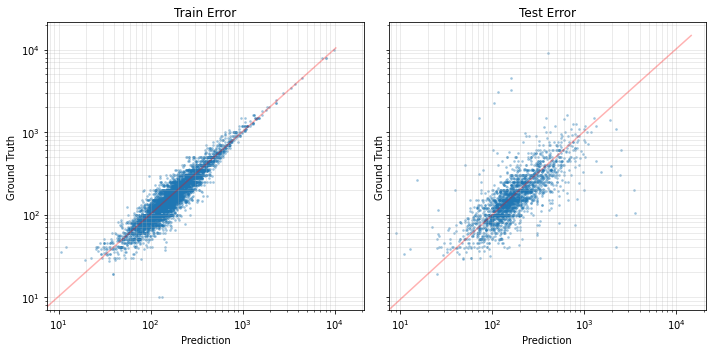

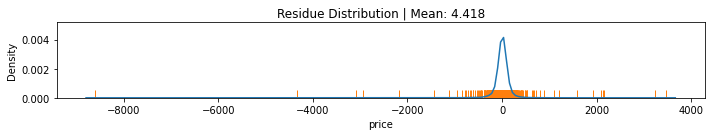

LGBMRegressor


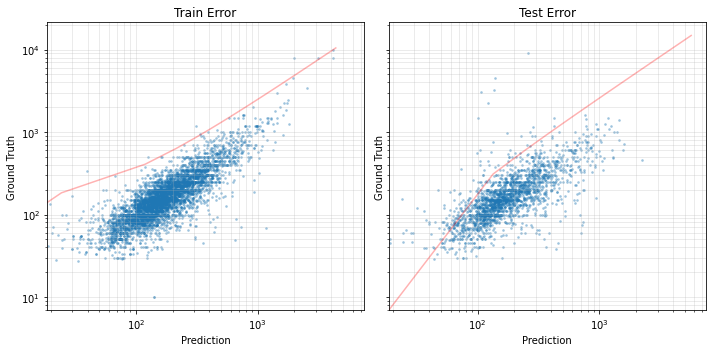

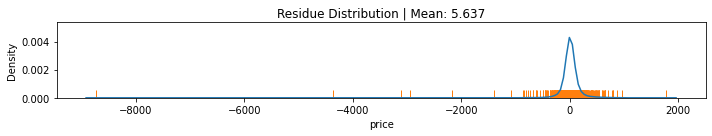

CatBoostRegressor


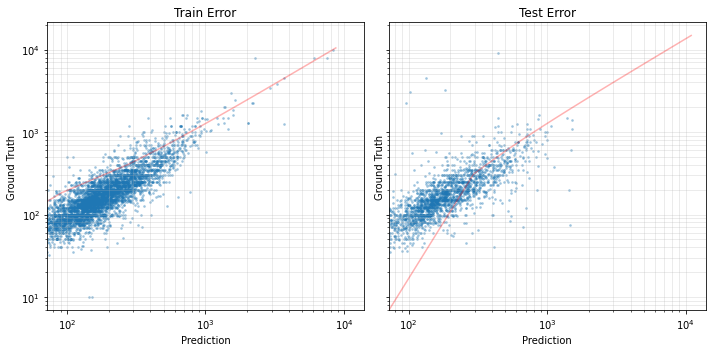

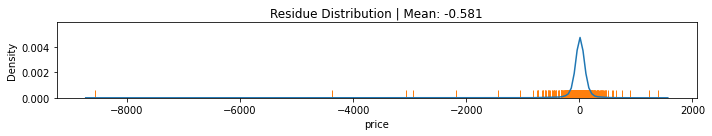

In [52]:
models = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    XGBRegressor(),
    LGBMRegressor(),
    CatBoostRegressor(cat_features=[col for col in X_train.columns if str(X_train.dtypes[col]) == 'category'], verbose=0)
]

for model in models:
    modelname = type(model).__name__
    print(modelname)
    if modelname == 'XGBRegressor':
        # XGB DOES NOT SUPPORT CATEGORICAL TYPES
        mapper = {row['index']: 'int' for _, row in X_train.dtypes.reset_index().iterrows() if str(row[0]) == 'category'}
        sets = (X_train.copy().astype(mapper), y_train.copy(), X_test.copy().astype(mapper), y_test.copy())
    else:
        sets = (X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy())
    mevals[('max_change', modelname)] = test_model(model, sets)

In [53]:
pd.DataFrame(mevals).transpose()

MSE        RMSE         MAE  \
min_change DecisionTreeRegressor  121835.847481  349.049921   98.088153   
           RandomForestRegressor   99065.306112  314.746416   77.260928   
           XGBRegressor           104159.949448  322.738206   80.799053   
           LGBMRegressor           96939.027609  311.350329   81.665777   
           CatBoostRegressor       96430.277981  310.532250   77.925186   
med_change DecisionTreeRegressor  160090.790578  400.113472  108.430504   
           RandomForestRegressor  101251.988599  318.201176   81.393549   
           XGBRegressor           127463.498694  357.020306   92.948819   
           LGBMRegressor           96009.967615  309.854752   87.685232   
           CatBoostRegressor       92885.503070  304.771231   80.513899   
max_change DecisionTreeRegressor  119897.120336  346.261636   97.257463   
           RandomForestRegressor   72372.883489  269.022087   76.887822   
           XGBRegressor            89909.126391  299.848506   85.957372   
           LGBMRegressor           76008.676305  275.696711   87.882171   
           CatBoostRegressor       69156.667122  262.976552   76.093216   

                                      MAPE       MaxErr  
min_change DecisionTreeRegressor  0.433073  9650.000000  
           RandomForestRegressor  0.380651  9667.100000  
           XGBRegressor           0.413412  9731.302490  
           LGBMRegressor          0.435797  9686.009924  
           CatBoostRegressor      0.406516  9603.895304  
med_change DecisionTreeRegressor  0.488585  9751.000000  
           RandomForestRegressor  0.379120  9669.430000  
           XGBRegressor           0.473630  9780.857254  
           LGBMRegressor          0.423749  9715.624661  
           CatBoostRegressor      0.390784  9661.483459  
max_change DecisionTreeRegressor  0.449488  8770.000000  
           RandomForestRegressor  0.359900  8541.450000  
           XGBRegressor           0.434568  8601.308167  
           LGBMRegressor          0.452086  8742.064431  
           CatBoostRegressor      0.373242  8557.686426

### Test best models with cross validation and hyper-opt

In [54]:
default_evals = pd.DataFrame(mevals).transpose().sort_values('MSE')
default_evals

MSE        RMSE         MAE  \
max_change CatBoostRegressor       69156.667122  262.976552   76.093216   
           RandomForestRegressor   72372.883489  269.022087   76.887822   
           LGBMRegressor           76008.676305  275.696711   87.882171   
           XGBRegressor            89909.126391  299.848506   85.957372   
med_change CatBoostRegressor       92885.503070  304.771231   80.513899   
           LGBMRegressor           96009.967615  309.854752   87.685232   
min_change CatBoostRegressor       96430.277981  310.532250   77.925186   
           LGBMRegressor           96939.027609  311.350329   81.665777   
           RandomForestRegressor   99065.306112  314.746416   77.260928   
med_change RandomForestRegressor  101251.988599  318.201176   81.393549   
min_change XGBRegressor           104159.949448  322.738206   80.799053   
max_change DecisionTreeRegressor  119897.120336  346.261636   97.257463   
min_change DecisionTreeRegressor  121835.847481  349.049921   98.088153   
med_change XGBRegressor           127463.498694  357.020306   92.948819   
           DecisionTreeRegressor  160090.790578  400.113472  108.430504   

                                      MAPE       MaxErr  
max_change CatBoostRegressor      0.373242  8557.686426  
           RandomForestRegressor  0.359900  8541.450000  
           LGBMRegressor          0.452086  8742.064431  
           XGBRegressor           0.434568  8601.308167  
med_change CatBoostRegressor      0.390784  9661.483459  
           LGBMRegressor          0.423749  9715.624661  
min_change CatBoostRegressor      0.406516  9603.895304  
           LGBMRegressor          0.435797  9686.009924  
           RandomForestRegressor  0.380651  9667.100000  
med_change RandomForestRegressor  0.379120  9669.430000  
min_change XGBRegressor           0.413412  9731.302490  
max_change DecisionTreeRegressor  0.449488  8770.000000  
min_change DecisionTreeRegressor  0.433073  9650.000000  
med_change XGBRegressor           0.473630  9780.857254  
           DecisionTreeRegressor  0.488585  9751.000000

In [55]:
def rank(s):
    order = s.index
    aux = pd.DataFrame(s.sort_values())
    aux['rank'] = [i for i in range(len(aux))]

    return aux['rank'].loc[order]

In [56]:
ranks = default_evals.apply(rank, axis=0)
ranks

MSE  RMSE  MAE  MAPE  MaxErr
max_change CatBoostRegressor        0     0    0     1       1
           RandomForestRegressor    1     1    1     0       0
           LGBMRegressor            2     2   10    12       3
           XGBRegressor             3     3    8     9       2
med_change CatBoostRegressor        4     4    4     4       7
           LGBMRegressor            5     5    9     7      11
min_change CatBoostRegressor        6     6    3     5       5
           LGBMRegressor            7     7    7    10      10
           RandomForestRegressor    8     8    2     3       8
med_change RandomForestRegressor    9     9    6     2       9
min_change XGBRegressor            10    10    5     6      12
max_change DecisionTreeRegressor   11    11   12    11       4
min_change DecisionTreeRegressor   12    12   13     8       6
med_change XGBRegressor            13    13   11    13      14
           DecisionTreeRegressor   14    14   14    14      13

### End Result Rank Evaluation

In [57]:
default_evals['avg-rank'] = ranks.mean(axis=1)
default_evals.sort_values('avg-rank')

MSE        RMSE         MAE  \
max_change CatBoostRegressor       69156.667122  262.976552   76.093216   
           RandomForestRegressor   72372.883489  269.022087   76.887822   
med_change CatBoostRegressor       92885.503070  304.771231   80.513899   
max_change XGBRegressor            89909.126391  299.848506   85.957372   
min_change CatBoostRegressor       96430.277981  310.532250   77.925186   
max_change LGBMRegressor           76008.676305  275.696711   87.882171   
min_change RandomForestRegressor   99065.306112  314.746416   77.260928   
med_change RandomForestRegressor  101251.988599  318.201176   81.393549   
           LGBMRegressor           96009.967615  309.854752   87.685232   
min_change LGBMRegressor           96939.027609  311.350329   81.665777   
           XGBRegressor           104159.949448  322.738206   80.799053   
max_change DecisionTreeRegressor  119897.120336  346.261636   97.257463   
min_change DecisionTreeRegressor  121835.847481  349.049921   98.088153   
med_change XGBRegressor           127463.498694  357.020306   92.948819   
           DecisionTreeRegressor  160090.790578  400.113472  108.430504   

                                      MAPE       MaxErr  avg-rank  
max_change CatBoostRegressor      0.373242  8557.686426       0.4  
           RandomForestRegressor  0.359900  8541.450000       0.6  
med_change CatBoostRegressor      0.390784  9661.483459       4.6  
max_change XGBRegressor           0.434568  8601.308167       5.0  
min_change CatBoostRegressor      0.406516  9603.895304       5.0  
max_change LGBMRegressor          0.452086  8742.064431       5.8  
min_change RandomForestRegressor  0.380651  9667.100000       5.8  
med_change RandomForestRegressor  0.379120  9669.430000       7.0  
           LGBMRegressor          0.423749  9715.624661       7.4  
min_change LGBMRegressor          0.435797  9686.009924       8.2  
           XGBRegressor           0.413412  9731.302490       8.6  
max_change DecisionTreeRegressor  0.449488  8770.000000       9.8  
min_change DecisionTreeRegressor  0.433073  9650.000000      10.2  
med_change XGBRegressor           0.473630  9780.857254      12.8  
           DecisionTreeRegressor  0.488585  9751.000000      13.8

* **Models to further validate**
  - `max_change | CatBoostRegressor`
  - `max_change | RandomForestRegressor`

In [73]:
aux = max_change.copy()
y = aux.pop('price')
X = aux

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6431, 4), (715, 4), (6431,), (715,))

In [74]:
final_res = dict()

### CatBoost

[Suggested Parameter Tuning](https://catboost.ai/docs/concepts/parameter-tuning.html)

In [75]:
default_cb = {
    'iterations': 100,
    'learning_rate': .1,
    'depth': 10,
    'l2_leaf_reg': 1,
    'max_bin': 254
}

In [76]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 80, 200),
        'learning_rate': trial.suggest_uniform('learning_rate', .01, .2),
        'depth': trial.suggest_int('depth', 2, 16),
        'l2_leaf_reg': trial.suggest_uniform('l2_leaf_reg', 1, 10),
        'max_bin': trial.suggest_int('max_bin', 50, 300)
    }

    estimator = CatBoostRegressor(**params, cat_features=[col for col in X_train.columns if str(X_train.dtypes[col]) == 'category'], verbose=0)
    cv_results = cross_validate(estimator, X=X_train, y=y_train, cv=10, scoring='neg_mean_squared_error')
    return np.mean(cv_results['test_score'])

In [77]:
study = opt.create_study(direction='maximize', study_name='CatBoostRegressor')

study.optimize(objective, n_trials=10, n_jobs=7)

[I 2020-10-31 20:14:08,586] A new study created in memory with name: CatBoostRegressor
[I 2020-10-31 20:14:22,480] Trial 4 finished with value: -95040.44581959276 and parameters: {'iterations': 116, 'learning_rate': 0.111620851668705, 'depth': 4, 'l2_leaf_reg': 2.343194856531112, 'max_bin': 86}. Best is trial 4 with value: -95040.44581959276.
[I 2020-10-31 20:14:22,875] Trial 6 finished with value: -95125.76997706953 and parameters: {'iterations': 122, 'learning_rate': 0.0877252972548329, 'depth': 4, 'l2_leaf_reg': 7.263260684545061, 'max_bin': 75}. Best is trial 4 with value: -95040.44581959276.
[I 2020-10-31 20:14:28,237] Trial 2 finished with value: -97833.2302761753 and parameters: {'iterations': 104, 'learning_rate': 0.10418551840758637, 'depth': 10, 'l2_leaf_reg': 1.3130384176414331, 'max_bin': 76}. Best is trial 4 with value: -95040.44581959276.
[I 2020-10-31 20:14:32,360] Trial 8 finished with value: -95887.0582003138 and parameters: {'iterations': 141, 'learning_rate': 0.04426

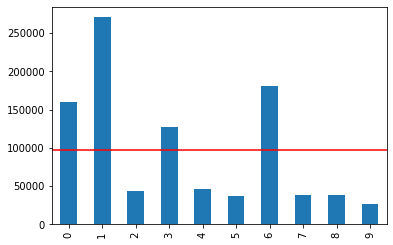

-97086.01774040583

In [78]:
estimator = CatBoostRegressor(**default_cb, cat_features=[col for col in X_train.columns if str(X_train.dtypes[col]) == 'category'], verbose=0)
cv_results = cross_validate(estimator, X=X_train, y=y_train, cv=10, scoring='neg_mean_squared_error')
default = np.mean(cv_results['test_score'])

pd.DataFrame(cv_results['test_score'] * -1).plot.bar(legend=False)
plt.axhline(default * -1, color='red')
plt.show()
plt.close()

default

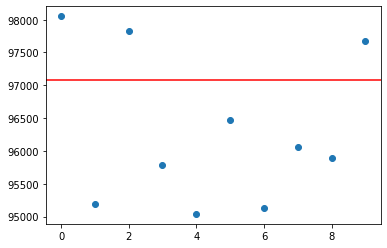

In [79]:
resdf = study.trials_dataframe()
plt.scatter(resdf['number'], -1 * resdf['value'])
plt.axhline(-1 * default, color='red')

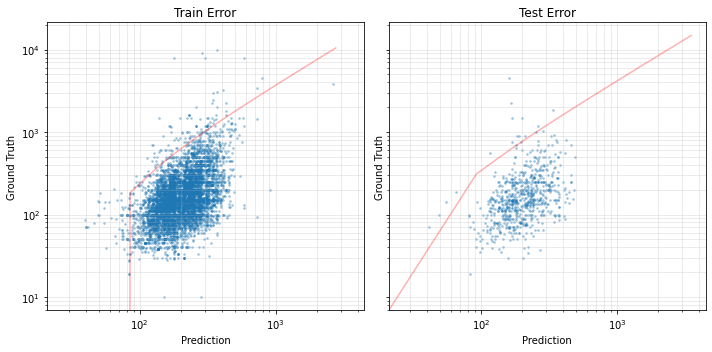

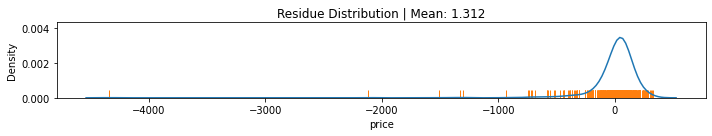

In [80]:
params_touse = study.best_params if study.best_value > default else default_rf
model = CatBoostRegressor(**params_touse, cat_features=[col for col in X_train.columns if str(X_train.dtypes[col]) == 'category'], verbose=0)

model.fit(X_train, y_train)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

pred = model.predict(X_train)
_ = prediction_report(y_train, pred, model, ax1, 'Train Comparison')

pred = model.predict(X_test)
final_res['CatBoostRegressor'] = prediction_report(y_test, pred, model, ax2, 'Test Comparison')

plt.tight_layout()
plt.show()
plt.close()

residue = pred - y_test
plt.figure(figsize=(10, 2))
plt.title(f'Residue Distribution | Mean: {residue.mean():.03f}')
sns.kdeplot(residue)
sns.rugplot(pred - y_test, height=0.1)
plt.tight_layout()
plt.show()
plt.close()

### RandomForests

In [81]:
default_rf = {
    'n_estimators': 100,
    'criterion': 'mse',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'min_weight_fraction_leaf': 0.0,
    'max_features': 'auto',
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'min_impurity_split': None,
    'bootstrap': True,
    'oob_score': False,
    'n_jobs': None,
    'random_state': None,
    'verbose': 0,
    'warm_start': False,
    'ccp_alpha': 0.0,
    'max_samples': None
}

In [82]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 80, 200),
        'criterion': 'mse',
        'max_depth': trial.suggest_int('max_depth', 10, 40),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 4, 15),
        'max_features': trial.suggest_uniform('max_features', .7, .9),
        'max_samples': trial.suggest_uniform('max_samples', .7, .9)
    }

    estimator = RandomForestRegressor(**params)
    cv_results = cross_validate(estimator, X=X_train, y=y_train, cv=10, scoring='neg_mean_squared_error')
    return np.mean(cv_results['test_score'])

In [83]:
study = opt.create_study(direction='maximize', study_name='RandomForestRegressor')

study.optimize(objective, n_trials=10, n_jobs=7)

[I 2020-10-31 20:15:54,389] A new study created in memory with name: RandomForestRegressor
[I 2020-10-31 20:16:02,732] Trial 0 finished with value: -95643.97050634034 and parameters: {'n_estimators': 83, 'max_depth': 38, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 0.7003971435092665, 'max_samples': 0.8707397753586472}. Best is trial 0 with value: -95643.97050634034.
[I 2020-10-31 20:16:06,152] Trial 6 finished with value: -96019.27979947026 and parameters: {'n_estimators': 107, 'max_depth': 36, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 0.8415903995319958, 'max_samples': 0.889046280254742}. Best is trial 0 with value: -95643.97050634034.
[I 2020-10-31 20:16:08,825] Trial 1 finished with value: -95853.96356198066 and parameters: {'n_estimators': 135, 'max_depth': 33, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 0.8724182666093402, 'max_samples': 0.7510322035604344}. Best is trial 0 with value: -95643.97050634034.
[I 2020-10-31 2

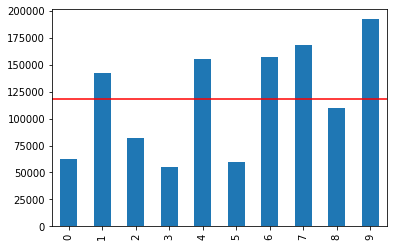

-118345.03032486634

In [84]:
estimator = RandomForestRegressor(**default_rf)
cv_results = cross_validate(estimator, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
default = np.mean(cv_results['test_score'])

pd.DataFrame(cv_results['test_score'] * -1).plot.bar(legend=False)
plt.axhline(default * -1, color='red')
plt.show()
plt.close()

default

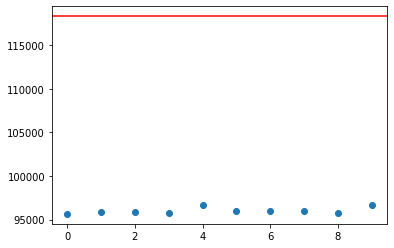

In [85]:
resdf = study.trials_dataframe()
plt.scatter(resdf['number'], -1 * resdf['value'])
plt.axhline(-1 * default, color='red')

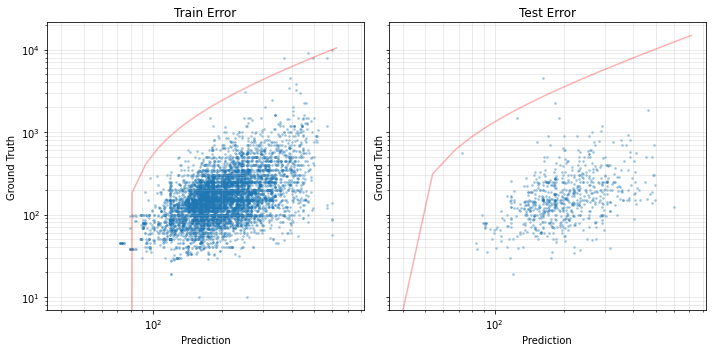

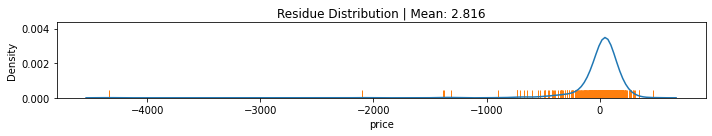

In [86]:
params_touse = study.best_params if study.best_value > default else default_rf
model = RandomForestRegressor(**params_touse)

model.fit(X_train, y_train)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

pred = model.predict(X_train)
_ = prediction_report(y_train, pred, model, ax1, 'Train Comparison')

pred = model.predict(X_test)
final_res['RandomForestRegressor'] = prediction_report(y_test, pred, model, ax2, 'Test Comparison')

plt.tight_layout()
plt.show()
plt.close()

residue = pred - y_test
plt.figure(figsize=(10, 2))
plt.title(f'Residue Distribution | Mean: {residue.mean():.03f}')
sns.kdeplot(residue)
sns.rugplot(pred - y_test, height=0.1)
plt.tight_layout()
plt.show()
plt.close()

### Final Results

In [87]:
pd.DataFrame(final_res).transpose()

,MSE,RMSE,MAE,MAPE,MaxErr
CatBoostRegressor,62220.113402,249.439599,114.655314,0.701710,4339.634150
RandomForestRegressor,62348.227368,249.696270,115.782956,0.711879,4338.418213


## Best Regression Model - CatBoost

---